In [1]:
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import torch as tc
import torch.nn as nn
import tcellmatch.api as tm

# Load Model

In [2]:
saved_model_path = '../tutorial_data/saved_model-8-2--18:56'
ffn = tm.models.EstimatorFfn()
ffn.load_model_full(fn=saved_model_path, load_train_data=False)

device = 'cuda' if tc.cuda.is_available() else 'cpu'
# device='cpu'
ffn.model = ffn.model.to(device) 
for param in ffn.model.parameters():
    param = param.to(device) 

In [3]:
ffn.predict()

# Define helpers
## and hyperparameters

In [4]:
N_SAMPLES = 10
length_param = np.median(np.abs(ffn.y_test[:, None] - ffn.y_test[None, :])) + 1e-6

In [5]:
# calculate reference vars for second term, (ε_i | ε_j)_k
def k(y, y_):
    # take sigma squared to be y
    return tc.exp(-1/(2 * length_param) * (tc.log(y + 1) - tc.log(y_ + 1)) ** 2)
def c(lmd1, lmd2):
    # a and b are lambda values
    delta_E = lmd1 - lmd2
    delta_sd = tc.sqrt(lmd1) - tc.sqrt(lmd2)
    return tc.exp(-1/(2 * length_param ** 2) * (delta_E ** 2 + delta_sd ** 2))

In [6]:
def mmd_pois(y_hat_mtx, y_mtx):
    # 1) prepare 
    y_hat_mtx, y_mtx = tc.Tensor(y_hat_mtx).to(device), tc.Tensor(y_mtx).to(device)
    n, n_antigens = y_hat_mtx.shape
    n = min(N_SAMPLES, n)
    samples_idx = tc.randperm(y_hat_mtx.size(0))[:N_SAMPLES]
    y_hat_mtx, y_mtx = y_hat_mtx[samples_idx], y_mtx[samples_idx]
    # acct for log lmd
    y_hat_mtx = tc.exp(y_hat_mtx)
    

    out = tc.zeros(n_antigens, device=device)

    # 3) Look at each antigen
    for col in range(n_antigens):
        # 1) compute matrix for each value of C term
        y, y_hat = y_mtx[:, col], y_hat_mtx[:, col]
        C = c(y_hat[:, None], y_hat[None, :]) # shape n x n
        # 2) Compute matrix for the expected value over BOTH inputs to the kernel, E k(y, y')
        # create matrix of samples:
        # samples_one_{ij} = jth sample from Pois(y_hat_i)
        s = 1000
        samples_one = tc.poisson(y_hat[:, None].expand(n, s)) # shape n x s
        samples_two = tc.poisson(y_hat[:, None].expand(n, s))

        # Reshape for broadcasting
        samples_a = samples_one[:, None, :, None] 
        samples_b = samples_two[None, :, None, :]
        # Compute k for each combination of draws
        # - call this matrix B for EV over BOTH inputs
        B = k(samples_a, samples_b) # shape n x n x s x s
        
        # 3) Compute E k(y, y_i)
        # reshape y for broadcasting
        y_reshaped = y[:, None, None]
        samples_three = tc.poisson(y_hat[:, None].expand(n, s)).unsqueeze(0)
        # # compute k for each combination
        M = k(y_reshaped, samples_three) # shape n x n x s
        # 4) Compute the eNd term, N_{ij} = k(y_i, y_j)
        N = k(y_hat[:, None], y_hat[None, :]) # shape n x n
        
        # 5) Put it all together
        # we want all mcs to be of shape n x n
        # take average over samples        
        B = B.mean(dim=(-2, -1))
        M = M.mean(dim=-1)
        K = B - 2 * M + N
        ans = (C * K).mean()
        out[col] = ans
        tc.cuda.empty_cache()
        del B
        del M
        del N
        del C
        del K
    return out

In [7]:
y_hat_mtx, y_mtx = ffn.predictions, ffn.y_test + 1
out = mmd_pois(y_hat_mtx, y_mtx)

Text(0, 0.5, 'Frequency')

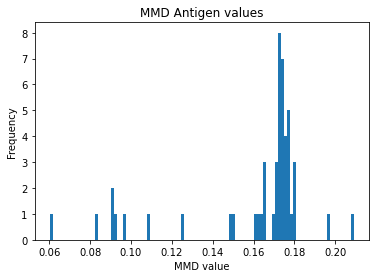

In [8]:
plt.hist(out.cpu(), bins=100)
plt.title(f"MMD Antigen values")
plt.xlabel("MMD value")
plt.ylabel("Frequency")

# Calculate $p$-value

In [9]:
p_lmd = tc.nn.PoissonNLLLoss(log_input=True, full=True, reduction='none')
# pred, obs
p = p_lmd(tc.Tensor(y_hat_mtx), tc.Tensor(y_mtx)).mean(dim=0)

Text(0, 0.5, 'Frequency')

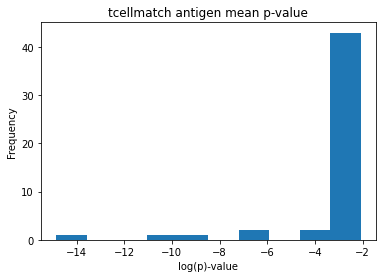

In [10]:
plt.hist(-p)
# TODO -> check the p-
plt.title(f"tcellmatch antigen mean p-value")
plt.xlabel("log(p)-value")
plt.ylabel("Frequency")

# Plot the Witness Function
$f(x) = E_{x' \sim \text{real digits}}[k(x, x')] - E_{x' \sim \text{GAN digits}}[k(x, x')]$
> "Difference in values of x"

1) embed x values
2) Plot the surface of the predicted lambda versus actual val

$f(x) = E_{x' \sim \text{Pois}(y)}[k(x, x')] - E_{x' \sim \text{Pois}(\lambda | X}}[k(x, x')]$

In [11]:
def f(mu, y):
    mu, y = tc.Tensor(np.exp(mu)).to(device), tc.Tensor(y).to(device)
    # c_term_{ij} = c(mu_i, mu_j)
    # plt.hist(tc.exp(mu).cpu(), bins=100, log=True)
    # plt.show()
    c_term = c(mu[:, None], mu[None, :])
    n_samples = 100
    # make broadcastable and sample n x s samples
    samples = tc.poisson(mu.unsqueeze(1).expand(-1, n_samples)).to(device)
    # k_expectation_{ijk} = k(y_i, kth sample from Pois(mu_j))
    k_expectation = k(y[:, None, None], samples[None, :, :]) # shape n x n x s
    # k_pairs_{ij} = k(E[mu_i], y_j)
    k_pairs = k(mu[:, None], y[None, :]) # shape n x n
    # take expectation over mu samples
    k_term = k_pairs - k_expectation.mean(dim=2)
    # sum over all datapoints
    k_term = (k_pairs - k_term).sum(dim=1)
    out = k_term * c_term.sum(1)
    return out

In [12]:
from scipy.interpolate import griddata
def plot_witness(col, n_samples=sys.maxsize):
    Z = f(y_hat_mtx[:n_samples, col], y_mtx[:n_samples, col])
    # plt.hist(Z[:n_samples].cpu(), bins=100, log=True)
    X = y_mtx[:n_samples, col]
    Y = y_hat_mtx[:n_samples, col]
    plt.hist(Y, log=True, bins=100)
    plt.title(f"Antigen {col} Witness Function Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()
    graph = np.column_stack((X, np.exp(Y), Z.cpu()))
    sorted_idcs = np.lexsort((graph[:,2], graph[:,1]))
    graph = graph[sorted_idcs]
    graph = graph[graph[:, 0] < 10]

    x_range = np.linspace(min(graph[:, 0]), max(graph[:, 0]), 100)
    y_range = np.linspace(min(graph[:, 1]), max(graph[:, 1]), 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = griddata(graph[:, :2], graph[:, 2], (X, Y), method='cubic')  # You can try different interpolation methods
    plt.imshow(Z, cmap='viridis', extent=(min(graph[:, 0]), max(graph[:, 0]), min(graph[:, 1]), max(graph[:, 1])),
               aspect='auto')  # 'auto' adjusts the aspect ratio based on the plot size
    plt.colorbar()  # Add a colorbar to indicate intensity values

    plt.title(f"Antigen {col} Witness Function")
    plt.xlabel("Actual Bind Count")
    plt.ylabel("Predicted Bind Count")
    plt.show()

In [13]:
plot_witness(15)

OutOfMemoryError: CUDA out of memory. Tried to allocate 30.04 GiB (GPU 0; 79.15 GiB total capacity; 30.34 GiB already allocated; 23.76 GiB free; 30.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.hist(f(y_hat_mtx[:1000, 41], y_mtx[:1000, 41]).cpu(), log=True, bins=100)

### Calculate p-value (U-statistic)

In [14]:
def bootstrap_mat(mat, b=100):
    """FROM THE PAPER
    Algorithm 1 Bootstrap Goodness-of-fit Test based on KSD
        Input: Sample {xi } and score function sq (x) = ∇x log q(x). Bootstrap sample size m.
        Test: H0: {xi} is drawn from q v.s H1: {xi} is not drawn from q.
        1. Compute Sˆu by (14) and uq(x,x′) as defined in The- orem 3.6. Generate m bootstrap sample Sˆ∗u by (16).
        2. Reject H0 with significance level α if the percentage of Sˆ∗u that satisfies Sˆ∗u > Sˆu is less than α.
    """
    """We bootstrap the degenerate U statistic assuming identical p, q.
    We can't use a usual bootstrap (wo -1/N) as dicussed in Arcones & Gine 1992:
    We want to perform the bootstrap on the first non-zero term in the Hoeffding decomposition,
    which in this case is the same U-stat with h(x, y) made degenerate. This sum will stay
    O(1/N) while the actual U-stat is O(1/sqrt(N))."""
    N = len(mat)
    ws = np.random.multinomial(N, np.ones(N)/N, b)
    mats = np.einsum('ij,bi,bj->bij', mat, (ws-1)/N, (ws-1)/N)
    return [ma.masked_array(mat_i, np.eye(len(mat))).sum() for mat_i in mats]
bootstrap_mat(ffn.predictions)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (8979,50)->(8979,50) (100,8979)->(100,8979,newaxis) (100,8979)->(100,newaxis,8979) 